<a href="https://colab.research.google.com/github/omarDrame/KaggleCompetition/blob/main/Compete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge

Season 6 Episode 3 

https://www.kaggle.com/competitions/playground-series-s3e6/overview/description

Credit : 
- My work was inspired by the following notebook ⁉

# Install and import

In [3]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
import xgboost as xgb 
import lightgbm as lgbm
import optuna
import warnings
warnings.simplefilter('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

In [5]:
path = '/content/drive/My Drive/Dev/Kaggle2/'
# Getting train data set
train = pd.read_csv(path +'train.csv').drop('id',axis=1)
target = 'price'
features = [c for c in train.columns if c not in [ target]]
# adding secondary data set
plus_train = pd.read_csv("/content/drive/My Drive/Dev/Kaggle2/add.csv")
train = pd.concat([train,plus_train]).reset_index(drop=True)

# Merging the whole data set
train['split']= 'train'
test = pd.read_csv(path +'test.csv').drop('id',axis=1)
test['split'] = 'test'
data = pd.concat([train,test]).reset_index(drop=True)
sub = pd.read_csv(path +'sample_submission.csv')

In [6]:
# Only one duplicated value, we're going to neglect it
print(data.shape)
data = data[~data.duplicated()]
data.shape

(47884, 18)


(47883, 18)

# Preprocessing

Only int variables, same length, seems clean

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47883 entries, 0 to 47883
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       47883 non-null  int64  
 1   numberOfRooms      47883 non-null  int64  
 2   hasYard            47883 non-null  int64  
 3   hasPool            47883 non-null  int64  
 4   floors             47883 non-null  int64  
 5   cityCode           47883 non-null  int64  
 6   cityPartRange      47883 non-null  int64  
 7   numPrevOwners      47883 non-null  int64  
 8   made               47883 non-null  int64  
 9   isNewBuilt         47883 non-null  int64  
 10  hasStormProtector  47883 non-null  int64  
 11  basement           47883 non-null  int64  
 12  attic              47883 non-null  int64  
 13  garage             47883 non-null  int64  
 14  hasStorageRoom     47883 non-null  int64  
 15  hasGuestRoom       47883 non-null  int64  
 16  price              327

In [8]:
data.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,split
0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2,train
1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0,train
2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1,train
3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2,train
4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8,train


## Real features

In [9]:
features = [f for f in train.columns if f not in ['split', target]]


## Feature ing

This column only brings noise to the model

In [10]:
data.info()
data = data.drop('cityCode',axis=1)
train = train.drop('cityCode',axis=1)
test = test.drop('cityCode',axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47883 entries, 0 to 47883
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       47883 non-null  int64  
 1   numberOfRooms      47883 non-null  int64  
 2   hasYard            47883 non-null  int64  
 3   hasPool            47883 non-null  int64  
 4   floors             47883 non-null  int64  
 5   cityCode           47883 non-null  int64  
 6   cityPartRange      47883 non-null  int64  
 7   numPrevOwners      47883 non-null  int64  
 8   made               47883 non-null  int64  
 9   isNewBuilt         47883 non-null  int64  
 10  hasStormProtector  47883 non-null  int64  
 11  basement           47883 non-null  int64  
 12  attic              47883 non-null  int64  
 13  garage             47883 non-null  int64  
 14  hasStorageRoom     47883 non-null  int64  
 15  hasGuestRoom       47883 non-null  int64  
 16  price              327

In [11]:
features = [f for f in train.columns if f not in ['split', target]]

## Outliers

We remove ouliers using the "2.5 sigma method"

In [12]:
summary = data.describe()
print(summary)

       squareMeters  numberOfRooms       hasYard       hasPool        floors  \
count  4.788300e+04   47883.000000  47883.000000  47883.000000  47883.000000   
mean   4.700141e+04      48.567362      0.485120      0.459620     47.639475   
std    4.011402e+04      28.346171      0.499784      0.498372     38.607340   
min    6.900000e+01       1.000000      0.000000      0.000000      1.000000   
25%    2.097800e+04      25.000000      0.000000      0.000000     25.000000   
50%    4.533900e+04      47.000000      0.000000      0.000000     46.000000   
75%    7.200350e+04      75.000000      1.000000      1.000000     70.000000   
max    6.071330e+06     100.000000      1.000000      1.000000   6000.000000   

       cityPartRange  numPrevOwners          made    isNewBuilt  \
count   47883.000000   47883.000000  47883.000000  47883.000000   
mean        5.579517       5.594365   2006.916171      0.475826   
std         2.764318       2.745511     82.114446      0.499421   
min        

In [13]:
from scipy.stats import zscore
train_normalized = train[features].apply(zscore)
outlier_mask = train_normalized[(~(train_normalized<2.5).all(axis=1))].index
train_normalized = train_normalized.drop(outlier_mask)
print(f"{len(outlier_mask)} values deleted")
train = train.drop(outlier_mask).reset_index(drop=True)
train.shape

20 values deleted


(32710, 17)

In [14]:
summary = train.describe()
print(summary)

        squareMeters  numberOfRooms       hasYard       hasPool        floors  \
count   32710.000000   32710.000000  32710.000000  32710.000000  32710.000000   
mean    47401.428523      48.882054      0.486090      0.466279     48.027117   
std     29149.721536      28.426149      0.499814      0.498869     27.562029   
min        89.000000       1.000000      0.000000      0.000000      1.000000   
25%     21581.000000      25.000000      0.000000      0.000000     25.000000   
50%     46131.000000      48.000000      0.000000      0.000000     46.000000   
75%     72545.000000      75.000000      1.000000      1.000000     72.000000   
max    146181.000000     100.000000      1.000000      1.000000    100.000000   

       cityPartRange  numPrevOwners          made    isNewBuilt  \
count   32710.000000   32710.000000  32710.000000  32710.000000   
mean        5.561602       5.590400   2006.013207      0.477530   
std         2.780897       2.758383      8.508673      0.499502   
mi

In [15]:
data = pd.concat([train,test]).reset_index(drop=True)

In [16]:
"""
features_cat = ['hasYard','hasPool', 'isNewBuilt', 'hasStormProtector']

features_num = ['squareMeters', 'numberOfRooms', 'floors', 'cityCode', 'cityPartRange', 'numPrevOwners','made', 'basement',
                'attic','garage', 'hasGuestRoom']
"""

"\nfeatures_cat = ['hasYard','hasPool', 'isNewBuilt', 'hasStormProtector']\n\nfeatures_num = ['squareMeters', 'numberOfRooms', 'floors', 'cityCode', 'cityPartRange', 'numPrevOwners','made', 'basement',\n                'attic','garage', 'hasGuestRoom']\n"

# EDA

## Feature distribution

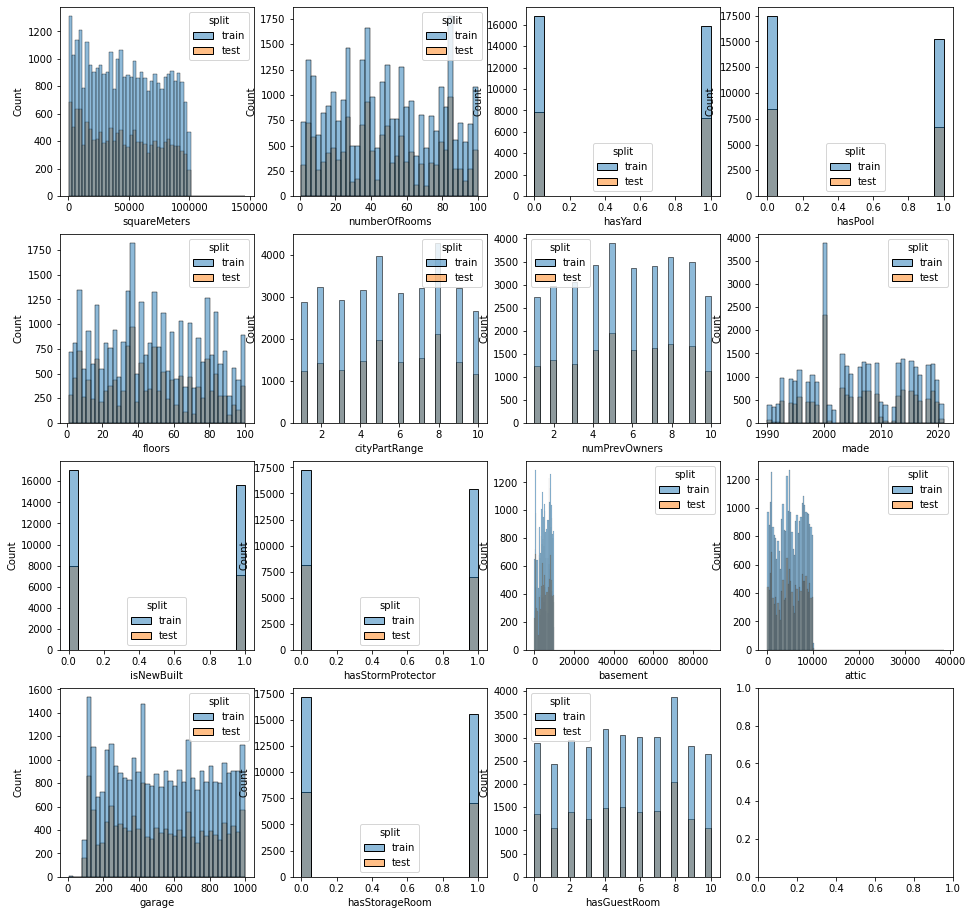

In [17]:
fig, axs = plt.subplots(4,4, figsize=(16,16))

for feature, ax in zip(features,axs.ravel()):
    sns.histplot(data, x=feature,hue='split', ax=ax)

## Linear correlations

**None of the variable are correlated**, such that it seems like we are working with principal components except for the **squareMeters** that is directly and completly correlated with the target **price**.

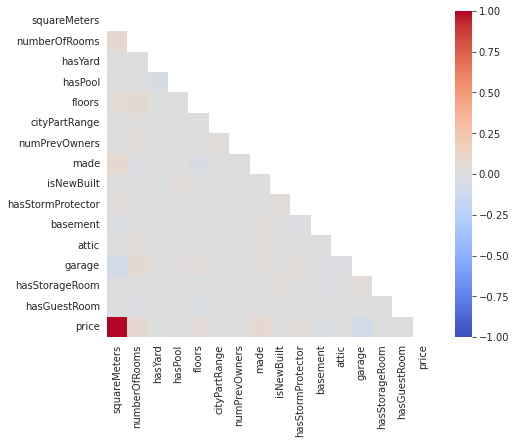

In [18]:
import matplotlib as plt2
mask = np.zeros_like(train.corr())

mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):

    f, ax = plt2.pyplot.subplots(figsize=(8, 6))

    ax = sns.heatmap(train.corr(), mask=mask, vmax=1, vmin=-1, square=True, cmap="coolwarm")

# Rmse

In [19]:
def rmse(y_test,y_pred):
  mse = mean_squared_error(y_test, y_pred)
  rmse = sqrt(mse)
  return rmse

## Choice of hyperparameters


### Knn

In [20]:
def objectiveKnn(trial):
    params_optuna = {
    'n_neighbors' : trial.suggest_int("n_neighbors", 1, 200),
    'weights' : trial.suggest_categorical("weights", ["uniform", "distance"]),
    'p' : trial.suggest_int("p", 1, 3),
    'leaf_size' : trial.suggest_int("leaf_size", 1, 200),
    'algorithm' : trial.suggest_categorical("algorithm", ["auto", "ball_tree", "kd_tree", "brute"])
    }



    model = KNeighborsRegressor(**params_optuna)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error').mean()

    return -score

### XBoost

In [21]:
def objectiveXB(trial):        
  params_optuna = {
            'max_depth': trial.suggest_int('max_depth', 1, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.01, 1.0),  
            'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 0.00, 0.1), 
            'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.00, 0.1),  
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.01, 1.0), 
            'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
            'alpha': trial.suggest_float('alpha', 0.01, 10),
            'validation_fraction': trial.suggest_float('validation_fraction', 0.01, 0.1),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'objective' : "reg:squarederror"
            }

  n = trial.suggest_int('n_cv', 3, 10)
  kf = KFold(n_splits=n, shuffle=True, random_state=42)
  fold_scores = []

  for train_index, val_index in kf.split(train):
      X_train, y_train = train.loc[train_index, features],train.loc[train_index, target]
      X_val, y_val = train.loc[val_index, features],train.loc[val_index, target]
      model = xgb.XGBRegressor(**params_optuna)
      model.fit(X_train,
                y_train,
                eval_set= [(X_val,y_val)],
                early_stopping_rounds = 50,
                verbose=500)
      pred_val = model.predict(X_val)
      score = rmse(y_val,pred_val)
      fold_scores.append(score)
  return np.mean(fold_scores)
 

### Random forest

In [22]:
def objectiveRF(trial):        
  params_optuna = {
      'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
      'max_depth': trial.suggest_int('max_depth', 4,10),
      'min_samples_split': trial.suggest_int('min_samples_split', 2, 100),
      'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 100),
      'min_impurity_decrease': trial.suggest_int('min_impurity_decrease', 0.0 ,0.9),
      'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
      'max_samples': trial.suggest_int('max_samples', 1, 14),}
      
  model = RandomForestRegressor(random_state=42, **params_optuna)

  kf = KFold(n_splits=5, shuffle=True, random_state=42)
  X_train, y_train = train_scaled.loc[:,features],train.loc[:, target]
  scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')

  return -scores.mean()




### light Xboost

In [23]:
def objectiveLXB(trial):        
  params_optuna = {
      'num_leaves': trial.suggest_int('num_leaves', 10, 100),
      'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
      'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
      'min_child_weight ': trial.suggest_int('min_child_weight ', 0.001, 0.01),
      'min_child_samples  ': trial.suggest_int('min_child_samples  ', 5, 100),
      'reg_alpha    ': trial.suggest_int('reg_alpha    ', 0.0, 0.9),
      'reg_lambda    ': trial.suggest_int('reg_lambda    ', 0.0, 0.9),
      'subsample   ': trial.suggest_int('subsample   ', 0.5, 1.5),
      'max_depth': trial.suggest_int('max_depth', 10, 11),
      'objective' : "regression"}

  n = trial.suggest_int('n_cv', 3, 10)
  kf = KFold(n_splits=n, shuffle=True, random_state=42)
  fold_scores = []
  for train_index, val_index in kf.split(train):
      X_train, y_train = train.loc[train_index, features],train.loc[train_index, target]
      X_val, y_val = train.loc[val_index, features],train.loc[val_index, target]
      model = lgbm.LGBMRegressor(**params_optuna)
      model.fit(X_train,
                y_train,
                eval_set= [(X_val,y_val)],
                early_stopping_rounds = 50,
                verbose=500)
      pred_val = model.predict(X_val)
      score = rmse(y_val,pred_val)
      fold_scores.append(score)
  return np.mean(fold_scores)

## Do hyperparameters Optimization

In [24]:
"""
study = optuna.create_study(direction='minimize')
study.optimize(func=objectiveLXB, n_trials=400)
study.best_params
"""

"\nstudy = optuna.create_study(direction='minimize')\nstudy.optimize(func=objectiveLXB, n_trials=400)\nstudy.best_params\n"

## Optimization results

### Optimal values for light xb

In [25]:
""" Underfitted
{'num_leaves': 41,
 'learning_rate': 0.10099910336832404,
 'n_estimators': 704,
 'min_child_weight ': 0,
 'min_child_samples  ': 18,
 'reg_alpha    ': 0,
 'reg_lambda    ': 0,
 'subsample   ': 0,
 'max_depth': 12,
 'n_cv': 9}
 
 LGB with less depth treees
 {'num_leaves': 90,
 'learning_rate': 0.2595129609517119,
 'n_estimators': 633,
 'min_child_weight ': 0,
 'min_child_samples  ': 10,
 'reg_alpha    ': 0,
 'reg_lambda    ': 0,
 'subsample   ': 1,
 'max_depth': 5,
 'n_cv': 9}

  LGB without outliers 
{'num_leaves': 34,
 'learning_rate': 0.055665980315090124,
 'n_estimators': 913,
 'min_child_weight ': 0,
 'min_child_samples  ': 67,
 'reg_alpha    ': 0,
 'reg_lambda    ': 0,
 'subsample   ': 0,
 'max_depth': 11,
 'n_cv': 10}
 """



" Underfitted\n{'num_leaves': 41,\n 'learning_rate': 0.10099910336832404,\n 'n_estimators': 704,\n 'min_child_weight ': 0,\n 'min_child_samples  ': 18,\n 'reg_alpha    ': 0,\n 'reg_lambda    ': 0,\n 'subsample   ': 0,\n 'max_depth': 12,\n 'n_cv': 9}\n \n LGB with less depth treees\n {'num_leaves': 90,\n 'learning_rate': 0.2595129609517119,\n 'n_estimators': 633,\n 'min_child_weight ': 0,\n 'min_child_samples  ': 10,\n 'reg_alpha    ': 0,\n 'reg_lambda    ': 0,\n 'subsample   ': 1,\n 'max_depth': 5,\n 'n_cv': 9}\n\n  LGB without outliers \n{'num_leaves': 34,\n 'learning_rate': 0.055665980315090124,\n 'n_estimators': 913,\n 'min_child_weight ': 0,\n 'min_child_samples  ': 67,\n 'reg_alpha    ': 0,\n 'reg_lambda    ': 0,\n 'subsample   ': 0,\n 'max_depth': 11,\n 'n_cv': 10}\n "

### Optimal values for xb

In [26]:
"""
# train
  {'max_depth': 4,
 'learning_rate': 0.11307741128639112,
 'min_samples_split': 0.8865596356926637,
 'min_weight_fraction_leaf': 0.03887565481662512,
 'min_impurity_decrease': 0.042591194582375314,
 'min_samples_leaf': 0.3204411171873966,
 'n_estimators': 922,
 'alpha': 3.777847931409453,
 'validation_fraction': 0.023778043383610167,
 'subsample': 0.9531912906350191,
 'n_cv': 9}

# train + added data 1
{'max_depth': 7,
 'learning_rate': 0.3016461196949007,
 'min_samples_split': 0.7364522409601838,
 'min_weight_fraction_leaf': 0.010978238137783808,
 'min_impurity_decrease': 0.06890580556157139,
 'min_samples_leaf': 0.6739620941900168,
 'n_estimators': 84,
 'alpha': 4.8173632456625315,
 'validation_fraction': 0.02716136946100349,
 'subsample': 0.6595354845045662,
 'n_cv': 9}

 train + added data 2 overfitted but with max deph from 8 -> 4 very good
 {'max_depth': 8,
 'learning_rate': 0.9474822265222392,
 'min_samples_split': 0.6854910650932633,
 'min_weight_fraction_leaf': 0.09838881024008651,
 'min_impurity_decrease': 0.007538877515429376,
 'min_samples_leaf': 0.08593850778683157,
 'n_estimators': 722,
 'alpha': 6.405870564690918,
 'validation_fraction': 0.02975861256097821,
 'subsample': 0.8892186045029851,
 'n_cv': 9}
 """

"\n# train\n  {'max_depth': 4,\n 'learning_rate': 0.11307741128639112,\n 'min_samples_split': 0.8865596356926637,\n 'min_weight_fraction_leaf': 0.03887565481662512,\n 'min_impurity_decrease': 0.042591194582375314,\n 'min_samples_leaf': 0.3204411171873966,\n 'n_estimators': 922,\n 'alpha': 3.777847931409453,\n 'validation_fraction': 0.023778043383610167,\n 'subsample': 0.9531912906350191,\n 'n_cv': 9}\n\n# train + added data 1\n{'max_depth': 7,\n 'learning_rate': 0.3016461196949007,\n 'min_samples_split': 0.7364522409601838,\n 'min_weight_fraction_leaf': 0.010978238137783808,\n 'min_impurity_decrease': 0.06890580556157139,\n 'min_samples_leaf': 0.6739620941900168,\n 'n_estimators': 84,\n 'alpha': 4.8173632456625315,\n 'validation_fraction': 0.02716136946100349,\n 'subsample': 0.6595354845045662,\n 'n_cv': 9}\n\n train + added data 2 overfitted but with max deph from 8 -> 4 very good\n {'max_depth': 8,\n 'learning_rate': 0.9474822265222392,\n 'min_samples_split': 0.6854910650932633,\n 'm

### Optimization for RF

In [27]:
"""
{'n_estimators': 990,
 'max_depth': 12,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_impurity_decrease': 0,
 'ccp_alpha ': 0,
 'max_features': 'sqrt',
 'max_samples': 14,
 'n_cv': 4}

# without outliers
{'n_estimators': 887,
 'max_depth': 8,
 'min_samples_split': 55,
 'min_samples_leaf': 1,
 'min_impurity_decrease': 0,
 'max_features': 'auto',
 'max_samples': 11}

 """

"\n{'n_estimators': 990,\n 'max_depth': 12,\n 'min_samples_split': 2,\n 'min_samples_leaf': 1,\n 'min_impurity_decrease': 0,\n 'ccp_alpha ': 0,\n 'max_features': 'sqrt',\n 'max_samples': 14,\n 'n_cv': 4}\n\n# without outliers\n{'n_estimators': 887,\n 'max_depth': 8,\n 'min_samples_split': 55,\n 'min_samples_leaf': 1,\n 'min_impurity_decrease': 0,\n 'max_features': 'auto',\n 'max_samples': 11}\n\n "

## Knn Values

In [28]:
"""
{'n_neighbors': 1,
 'weights': 'distance',
 'p': 1,
 'leaf_size': 56,
 'algorithm': 'ball_tree'}
 """

"\n{'n_neighbors': 1,\n 'weights': 'distance',\n 'p': 1,\n 'leaf_size': 56,\n 'algorithm': 'ball_tree'}\n "

## CV + ensemble of the best models
At the end fo numerous test, the best result is acheived with **only gradient boosting**.



In [29]:
k=9
kf = KFold(k, shuffle=True, random_state=42)
fold_scores = []
test_preds = []
oof_preds = []
oof_preds_1 = []
oof_preds_2 = []
oof_preds_3 = []
oof_true = []

for train_index, val_index in kf.split(train):                                            
    X_train = train.loc[train_index, features]
    y_train = train.loc[train_index, target]
    X_val = train.loc[train_index, features]
    y_val = train.loc[train_index, target]
    
    #GB -------------------------------------------
    
    params_xgb = {'max_depth': 4,
 'learning_rate': 0.9474822265222392,
 'min_samples_split': 0.6854910650932633,
 'min_weight_fraction_leaf': 0.09838881024008651,
 'min_impurity_decrease': 0.007538877515429376,
 'min_samples_leaf': 0.08593850778683157,
 'n_estimators': 722,
 'alpha': 6.405870564690918,
 'validation_fraction': 0.02975861256097821,
 'subsample': 0.8892186045029851,
 'n_cv': 9}
    model1 = xgb.XGBRegressor(**params_xgb)
    model1.fit(X_train,
             y_train,
             eval_set= [(X_val,y_val)],
             early_stopping_rounds = 200,
             verbose=1000)
    
    pred_val1 = model1.predict(X_val)
    
    score1 = rmse(y_val,pred_val1)
    if score1< 20000.:
        test_preds.append(model1.predict(test[features]))
        fold_scores.append(score1)
    
        
    # out of fold
    print(pred_val1)
    oof_preds.extend(pred_val1)
    oof_true.extend(y_val)
    print(f'=== Fold RMSE Score {[score1]} ===')
  
    
    
print()
print(f'=== Average RMSE Score {np.mean(fold_scores)} ===')
  

[721]	validation_0-rmse:8952.28615
[3434600.   9508547.   9278343.   ...  179558.7  8390265.    150352.16]
=== Fold RMSE Score [8952.286269320539] ===

=== Average RMSE Score 8177.450602613302 ===


In [30]:
fold_scores

[10299.136696998754,
 7930.8508194448505,
 7863.989141977353,
 7373.775899170606,
 8625.931241396764,
 6801.410339683163,
 7042.953554096889,
 8706.721461430805,
 8952.286269320539]

# RESULTS

In [31]:
score = rmse(oof_true, oof_preds)
print(f' OOF Score: {score:.5f}')

 OOF Score: 8242.19860
